## DeepWalk Implementation & Experiments

In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

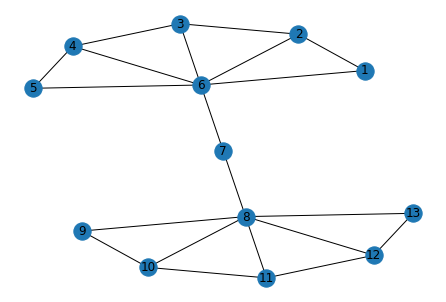

In [126]:
#Simple Graph for testing purposes
G = nx.Graph()
G.add_edge(7, 6)
G.add_edge(6, 1)
G.add_edge(6, 2)
G.add_edge(6, 3)
G.add_edge(6, 4)
G.add_edge(6, 5)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)
G.add_edge(7, 8)
G.add_edge(8, 9)
G.add_edge(8, 10)
G.add_edge(8, 11)
G.add_edge(8, 12)
G.add_edge(8, 13)
G.add_edge(9, 10)
G.add_edge(10, 11)
G.add_edge(11, 12)
G.add_edge(12, 13)
nx.draw_kamada_kawai(G, with_labels=True)

Implementation of DeepWalk:
- In each random walk, nodes can be revisited
- Using Word2Vec default parameters

In [132]:
class MyDeepWalk:
    
    def __init__(self, graph, 
                 embedding_dimension=128, 
                 num_walks = 80,
                 walk_length = 40):
        self.graph = graph
        self.embedding_dimension = embedding_dimension
        self.num_walks = num_walks
        self.walk_length = walk_length
    
    def random_walk(self, start_node):
        # Get a random walk from start_node with length = self.walk_length 
        # TODO think about revisiting nodes
        G = self.graph
        walk = [start_node]

        current_node = start_node
        for i in range(self.walk_length-1):
            neighbors = list(G[current_node]) 

            if len(neighbors)==0:
                return walks
            next_node = np.random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node
        return walk
    
    def random_walks(self):
        # Obtain self.num_walks random walks from all the nodes in the graph
        G = self.graph
        walks = list()
        
        for node in G.nodes():
            for i in range(self.num_walks):
                new_walk = self.random_walk(node)
                walks.append(new_walk)
        return walks
    
    def skipgram(self, walks):
        walks2 = [list(map(str, walk)) for walk in walks]
        model = Word2Vec(walks2,size=self.embedding_dimension)
        return model
    
    def learn_embeddings(self):
        random_walks = self.random_walks()
        model = self.skipgram(random_walks)
        return model

In [134]:
#aux function to transform nodes to string
def nodes_to_string(nodes):
    return list(map(str, nodes))

In [136]:
G_dw = MyDeepWalk(G, embedding_dimension=2)
G_model = G_dw.learn_embeddings() # the model 
G_embeddings = G_model.wv[nodes_to_string(G.nodes())] # the 2-D vectors

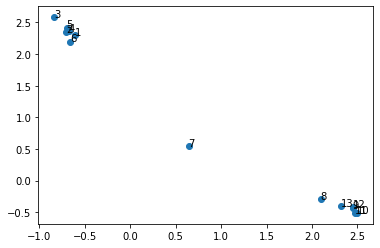

In [137]:
plt.scatter(G_embeddings[:,0], G_embeddings[:, 1])

for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_embeddings[i,0],G_embeddings[i,1]))

As shown in the image, nodes that should appear together are also together in the new 2D-representation

Another operations such as finding the most similar node can be computed:

In [154]:
G_model.wv.most_similar('8')

[('13', 0.9995176792144775),
 ('12', 0.9995072484016418),
 ('9', 0.9993544220924377),
 ('10', 0.9981591701507568),
 ('11', 0.9979116320610046),
 ('7', 0.6607588529586792),
 ('1', -0.3865894079208374),
 ('4', -0.40618157386779785),
 ('5', -0.4092121124267578),
 ('2', -0.419133722782135)]

Although it is visually obvious, let's apply K-means clustering to the 2D data

In [147]:
from sklearn.cluster import KMeans

In [148]:
km = KMeans(n_clusters=2).fit(G_embeddings)

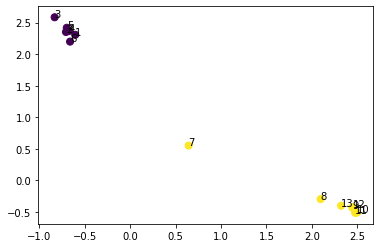

In [149]:
plt.scatter(G_embeddings[:, 0], G_embeddings[:, 1], c=km.predict(G_embeddings), s=50, cmap='viridis')
for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_embeddings[i,0],G_embeddings[i,1]))

### DeepWalk Embedding (dimensions = 128) and Dimensionality Reduction Using t-SNE

In [155]:
G_dw_2 = MyDeepWalk(G, embedding_dimension=128)
G_model_2 = G_dw_2.learn_embeddings()
G_embeddings_2 = G_model_2.wv[nodes_to_string(G.nodes())]

In [156]:
G_model_2.wv.most_similar('8')

[('9', 0.9982972145080566),
 ('12', 0.9978459477424622),
 ('13', 0.9976795315742493),
 ('10', 0.9972952008247375),
 ('11', 0.9969653487205505),
 ('7', 0.6598975658416748),
 ('6', -0.3047010600566864),
 ('5', -0.31381189823150635),
 ('4', -0.3217012882232666),
 ('1', -0.32673296332359314)]

Reduce dimensionality to 2 components using t-SNE:

In [157]:
G_tsne_2 = TSNE(n_components=2).fit_transform(G_embeddings_2)

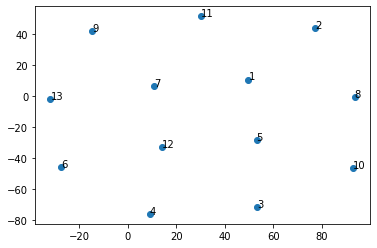

In [116]:
plt.scatter(G_tsne_2[:,0], G_tsne_2[:, 1])

for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_tsne_2[i,0],G_tsne_2[i,1]))

The idea of SNE and t-SNE is to place neighbors close to each other, (almost) completly ignoring the global structure.

This is excellent for visualization, because similar items can be plotted next to each other (and not on top of each other, c.f. crowding).

This is not good for further analysis. Global structure is lost, some objects may have been blocked from moving to their neighbors, and separation between different groups is not preserved quantitatively. Which is largely why e.g. clustering on the projection usually does not work very well.

PCA is quite the opposite. It tries to preserve the global properties (eigenvectors with high variance) while it may lose low-variance deviations between neighbors.

(from stackoverflow)

In [158]:
km = KMeans(n_clusters=2).fit(G_tsne_2)

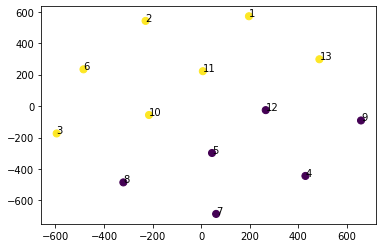

In [159]:
plt.scatter(G_tsne_2[:, 0], G_tsne_2[:, 1], c=km.predict(G_tsne_2), s=50, cmap='viridis')
for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_tsne_2[i,0],G_tsne_2[i,1]))

### DeepWalk Embedding (dimensions = 128) and Dimensionality Reduction Using PCA

In [160]:
from sklearn.decomposition import PCA

In [161]:
G_pca_2 = PCA(n_components=2).fit_transform(G_embeddings_2)

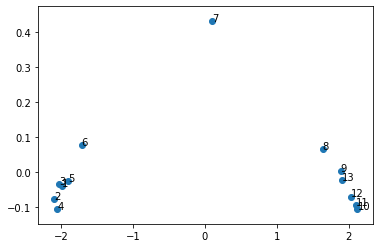

In [162]:
plt.scatter(G_pca_2[:,0], G_pca_2[:, 1])

for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_pca_2[i,0],G_pca_2[i,1]))

Structure of the graph is preserved (above).

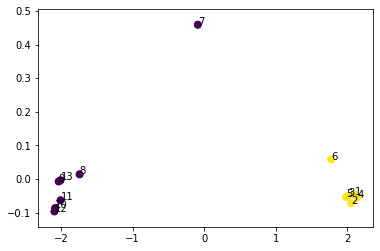

In [125]:
km_pca = KMeans(n_clusters=2).fit(G_pca_2)
plt.scatter(G_pca_2[:, 0], G_pca_2[:, 1], c=km_pca.predict(G_pca_2), s=50, cmap='viridis')
for i, node in enumerate(G.nodes()):
    plt.annotate(node, (G_pca_2[i,0],G_pca_2[i,1]))

### DeepWalk Test with a Larger (and More Interesting) Graph

In [165]:
got_book1 = pd.read_csv("/home/irene/dev/notebooks-jupyter/got_dataset/book1.csv")
# build graph from interactions (csv)
G_got = nx.Graph()
less_important_characters = list()
for _, edge in got_book1.iterrows():
        G_got.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])

In [181]:
G_dw_got = MyDeepWalk(G_got, embedding_dimension=256, num_walks=100, walk_length=20)
G_model_got = G_dw_got.learn_embeddings()
G_embeddings_got = G_model_got.wv[nodes_to_string(G_got.nodes())]

In [182]:
G_model_got.most_similar('Arya-Stark')

/home/irene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Mordane', 0.5774433612823486),
 ('Sansa-Stark', 0.5705544948577881),
 ('Syrio-Forel', 0.5568148493766785),
 ('Joffrey-Baratheon', 0.5493011474609375),
 ('Cersei-Lannister', 0.5198186635971069),
 ('Myrcella-Baratheon', 0.5114185810089111),
 ('Meryn-Trant', 0.5025807619094849),
 ('Jeyne-Poole', 0.5025264024734497),
 ('Mycah', 0.4863124489784241),
 ('Desmond', 0.4590061902999878)]

Dimensionality reduction using PCA (to 2D) for visualization purposes:

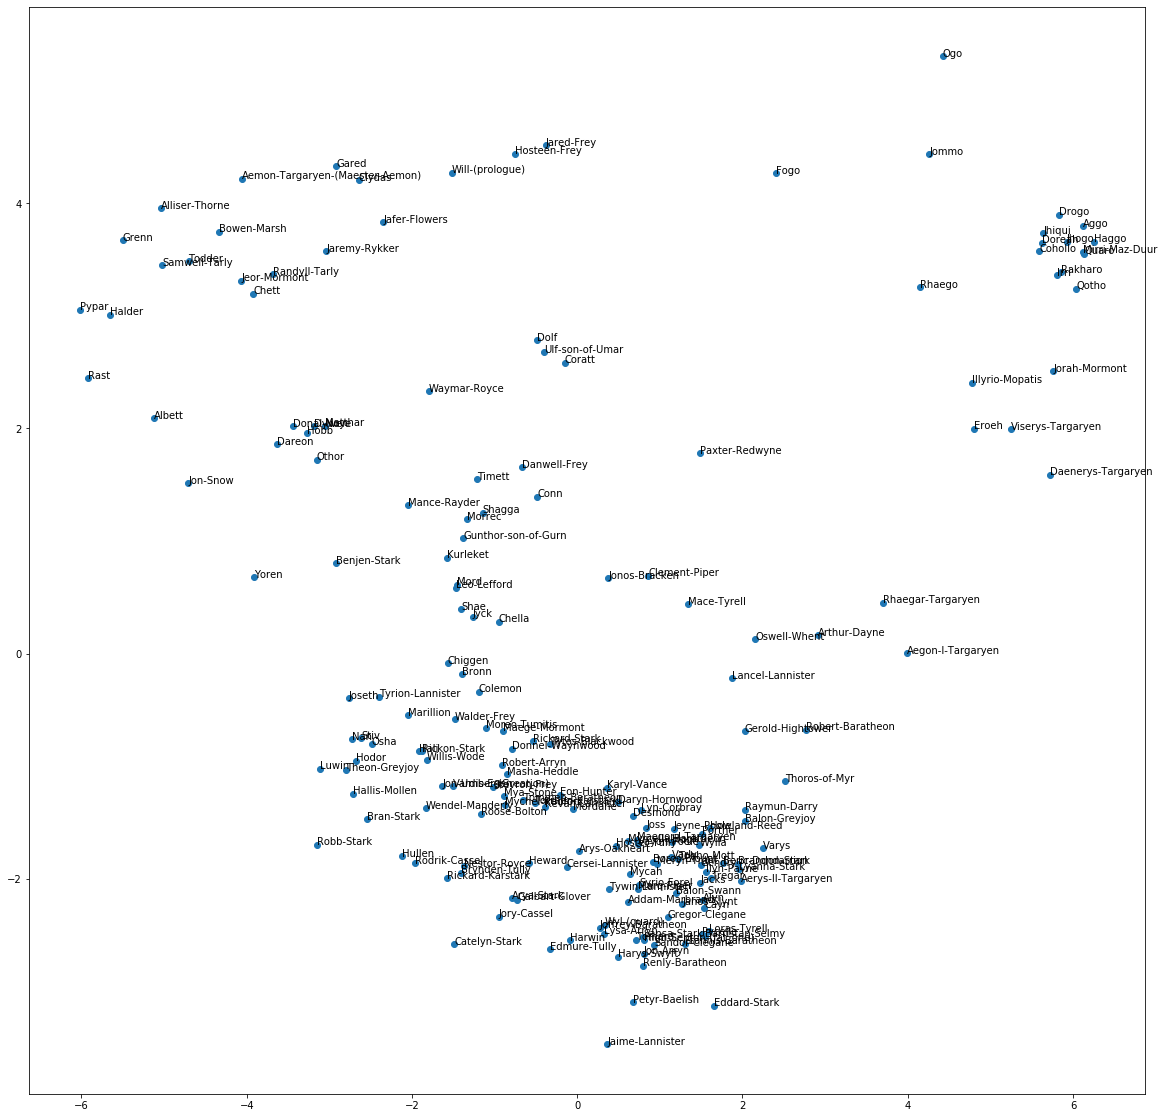

In [183]:
G_pca_got = PCA(n_components=2).fit_transform(G_embeddings_got)
plt.figure(figsize=[20,20])
plt.scatter(G_pca_got[:,0], G_pca_got[:, 1])


for i, node in enumerate(G_got.nodes()):
    plt.annotate(node, (G_pca_got[i,0],G_pca_got[i,1]))

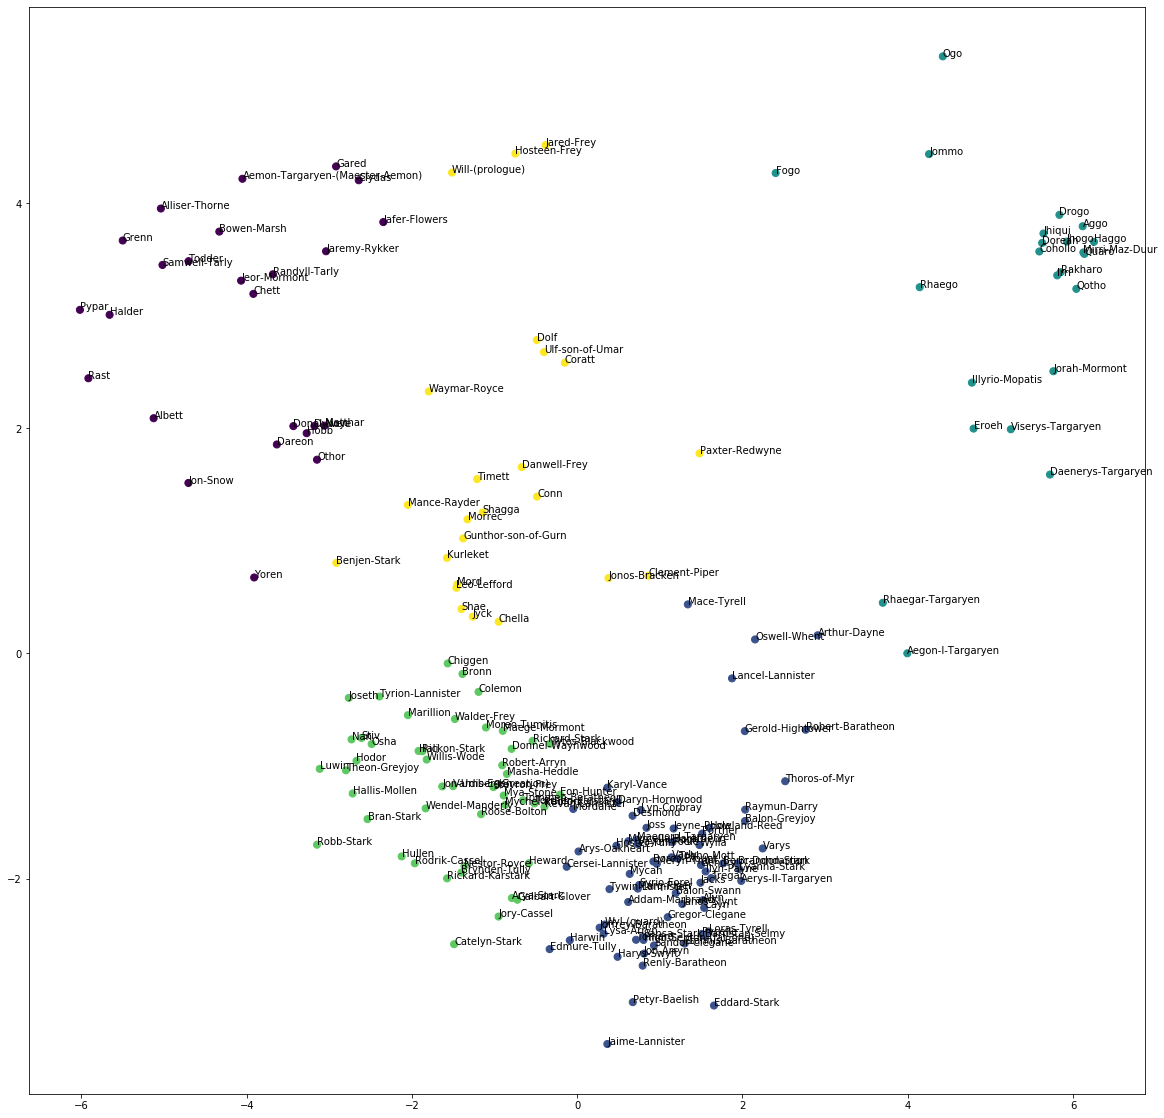

In [186]:
km_pca_got = KMeans(n_clusters=5).fit(G_pca_got)
plt.figure(figsize=[20,20])
plt.scatter(G_pca_got[:, 0], G_pca_got[:, 1], c=km_pca_got.predict(G_pca_got), s=50, cmap='viridis')
for i, node in enumerate(G_got.nodes()):
    plt.annotate(node, (G_pca_got[i,0],G_pca_got[i,1]))